The code in this repository is largely based on the work of Olga Ratushniak and Svitlana Myroshnychenko during their MSc thesis. For more information, please contact Beatriz Cabrero-Daniel.

In [19]:
import os
import pandas as pd
import csv
import time
import matplotlib.pyplot as plt
import random
import zCurve as z
import math

Some "utils" functions:

In [20]:
def get_files_in_folder(folder_path):
    try:
        files = [folder_path + "/" + f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return files
    except Exception as e:
        print(f"An error occurred while getting files in the folder: {str(e)}")
        return []
    
def compute_acceleration(pos_prev, pos_current, pos_next, dt):
    ax = (pos_next[0] - 2 * pos_current[0] + pos_prev[0]) / (dt ** 2)
    ay = (pos_next[1] - 2 * pos_current[1] + pos_prev[1]) / (dt ** 2)
    return ax, ay

def compute_relative_acceleration(pos_prev, pos_current, pos_next, dt):
    # Compute velocity vectors
    vx1 = (pos_current[0] - pos_prev[0]) / dt
    vy1 = (pos_current[1] - pos_prev[1]) / dt
    vx2 = (pos_next[0] - pos_current[0]) / dt
    vy2 = (pos_next[1] - pos_current[1]) / dt

    # Compute the change in velocity (acceleration vector)
    ax = (vx2 - vx1) / dt
    ay = (vy2 - vy1) / dt

    # Velocity direction (unit vector) at the middle position
    v_mag = math.hypot(vx1, vy1)
    if v_mag == 0:
        return 0.0, 0.0  # No motion

    # Tangential direction (unit vector)
    tx = vx1 / v_mag
    ty = vy1 / v_mag

    # Normal direction (perpendicular to tangential)
    nx = -ty
    ny = tx

    # Project acceleration onto tangential and normal directions
    a_tangential = ax * tx + ay * ty
    a_normal = ax * nx + ay * ny

    return a_normal, a_tangential

Fake data generation functions:

In [21]:
def generate_straight_trajectory(num_points=100, initial_speed=5, initial_angle=math.pi/2, filename="trajectory.csv", initial_x=0, initial_y=0):
    # Initialize variables
    position_x, position_y = initial_x, initial_y  # Start position
    previous_x, previous_y = initial_x, initial_y  # Start position

    turning_angle = initial_angle
    speed = initial_speed
    
    timestamp = 0
    delta_t = 4000  # Time step in microseconds

    # Open CSV file for writing
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerow(["sampleTimeStamp.seconds", "sampleTimeStamp.microseconds", "x", "y", "speed",
                         "turning_angle", "accel_x", "accel_y"])

        for i in range(-2, num_points):
            speed = initial_speed #- 2 * i/num_points
            previous_previous_x = previous_x
            previous_previous_y = previous_y
            previous_x = position_x
            previous_y = position_y
            position_x = position_x + math.cos(turning_angle) * speed * 16/delta_t
            position_y = position_y + math.sin(turning_angle) * speed * 16/delta_t
            acceleration_x, acceleration_y = compute_relative_acceleration((previous_previous_x, previous_previous_y), (previous_x, previous_y), (position_x, position_y), 16/delta_t)
            
            if i < 0:
                continue
            
            writer.writerow([int(timestamp / 1000000), timestamp % 1000000, position_x, position_y, speed, turning_angle, acceleration_x, acceleration_y])
            timestamp += delta_t
    
    return turning_angle, speed, position_x, position_y
 

def generate_turning_data_3(num_points=100, left=True, initial_angle=math.pi/2, maxangle=math.pi/2, filename="trajectory.csv", initial_x=0, initial_y=0, initial_speed=5):
    # Initialize variables
    position_x, position_y = initial_x, initial_y  # Start position
    previous_x, previous_y = initial_x, initial_y  # Start position
    
    turning_angle = initial_angle
    speed = initial_speed
    
    timestamp = 0
    delta_t = 4000  # Time step in microseconds
    padding = num_points//5

    # Open CSV file for writing
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerow(["sampleTimeStamp.seconds", "sampleTimeStamp.microseconds", "x", "y", "speed",
                         "turning_angle", "accel_x", "accel_y"])

        for i in range(-2, num_points):
            if padding < i < num_points - padding:     
                turning_angle = initial_angle - (i-padding)/(num_points-2*padding) * maxangle * (-1 if left else 1)

            speed = initial_speed #+ 2 * i/num_points #+ 0.01*math.sin(i/num_points*7*math.pi)
            previous_previous_x = previous_x
            previous_previous_y = previous_y
            previous_x = position_x
            previous_y = position_y
            position_x = position_x + math.cos(turning_angle) * speed * 16/delta_t
            position_y = position_y + math.sin(turning_angle) * speed * 16/delta_t
            
            acceleration_x, acceleration_y = compute_relative_acceleration((previous_previous_x, previous_previous_y), (previous_x, previous_y), (position_x, position_y), 50/delta_t)
            
            if i < 0:
                continue
            
            writer.writerow([int(timestamp / 1000000), timestamp % 1000000, position_x, position_y, speed, turning_angle, acceleration_x, acceleration_y])
            timestamp += delta_t
    
    return turning_angle, speed, position_x, position_y


Synthetic data generation:

In [22]:
maxangle = math.pi/3
length_tramo = 100
num_turns = 5
left = True

filename = "results/synthetic_trajectories/longer_trajectory_example3.csv"
turning_angle, speed, end_x, end_y = generate_straight_trajectory(num_points=length_tramo, initial_speed=5, initial_angle=0, filename=filename, initial_x=0, initial_y=0)
data1 = pd.read_csv(filename, sep=';')

for i in range(num_turns):
    turning_angle, speed, end_x, end_y = generate_turning_data_3(num_points=length_tramo, left=left, initial_angle=turning_angle, maxangle=maxangle, filename=filename, initial_x=end_x, initial_y=end_y, initial_speed=speed)
    data2 = pd.read_csv(filename, sep=';')
    data1 = pd.concat([data1, data2])
    data1["sampleTimeStamp.seconds"] = [t // 1000000 for t in range(0, 4000*(data1.shape[0]), 4000)]
    data1["sampleTimeStamp.microseconds"] = [t % 1000000 for t in range(0, 4000*(data1.shape[0]), 4000)]
    data1.to_csv(filename, index=False, sep=";")
    
    filename = "results/synthetic_trajectories/longer_trajectory_example3.csv"
    turning_angle, speed, end_x, end_y = generate_straight_trajectory(num_points=length_tramo, initial_speed=speed, initial_angle=turning_angle, filename=filename, initial_x=end_x, initial_y=end_y)
    data2 = pd.read_csv(filename, sep=';')
    data1 = pd.concat([data1, data2])
    data1["sampleTimeStamp.seconds"] = [t // 1000000 for t in range(0, 4000*(data1.shape[0]), 4000)]
    data1["sampleTimeStamp.microseconds"] = [t % 1000000 for t in range(0, 4000*(data1.shape[0]), 4000)]
    data1.to_csv(filename, index=False, sep=";")

Synthetic data visualisation:

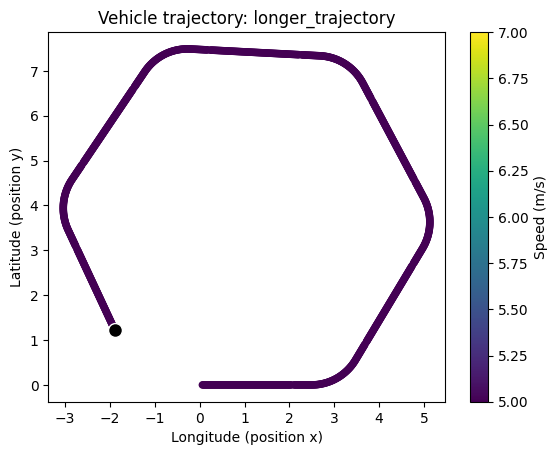

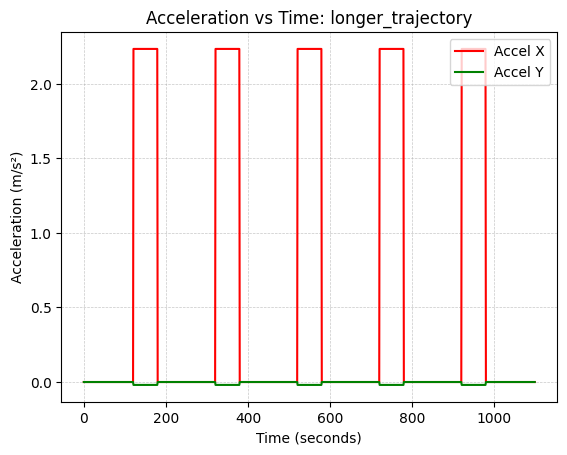

In [23]:
file_path = "results/synthetic_trajectories/longer_trajectory_example3.csv"
file_basename = os.path.splitext(os.path.basename(file_path))[0]
data = pd.read_csv(file_path, sep=';')    
data['timestamp'] = data['sampleTimeStamp.seconds'] * 1_000_000 + data['sampleTimeStamp.microseconds']

# ===============================
# Plot 1: Vehicle Position Colored by Speed
# ===============================    
plt.figure()
plt.scatter(data['x'], data['y'], c=data['speed'], cmap='viridis', s=20, vmin=5, vmax=7)
plt.colorbar(label="Speed (m/s)")
plt.scatter(data.iloc[-1]['x'], data.iloc[-1]['y'], s=100, color="black", edgecolors="white")
plt.xlabel("Longitude (position x)")
plt.ylabel("Latitude (position y)")
plt.title(f"Vehicle trajectory: {file_basename}")
plt.axis('equal')
plt.show()
plt.close()

# ===============================
# Plot 2: Raw Acceleration vs Time (No Smoothing)
# ===============================
min_accel_x = -3
min_accel_y = -3
max_accel_x = 3
max_accel_y = 3

accel_x = data["accel_x"]
accel_y = data["accel_y"]

plt.plot(accel_x, label="Accel X", color='red', linewidth=1.5)
plt.plot(accel_y, label="Accel Y", color='green', linewidth=1.5)
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (m/s²)")
plt.title(f"Acceleration vs Time: {file_basename}")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc="upper right")
plt.show()
plt.close()

It is interesting that the combinations of acceleration X and Y are so different for each of the turns even though they are similar manoeuvres (left turns turning the same angle) and thus should have similar CSPs. Let us look at each separate manoeuvre:

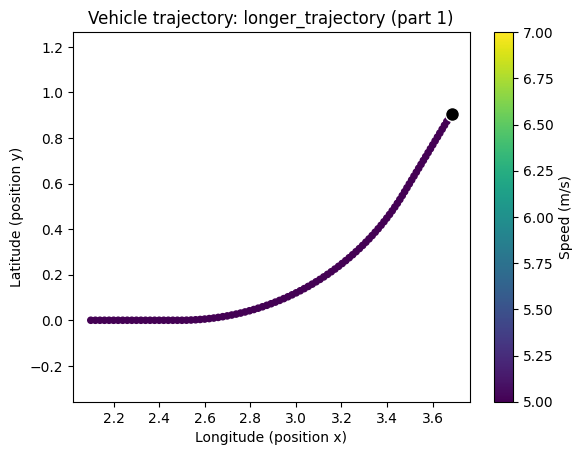

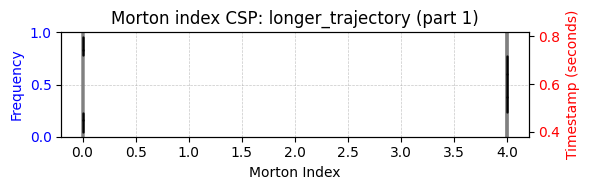

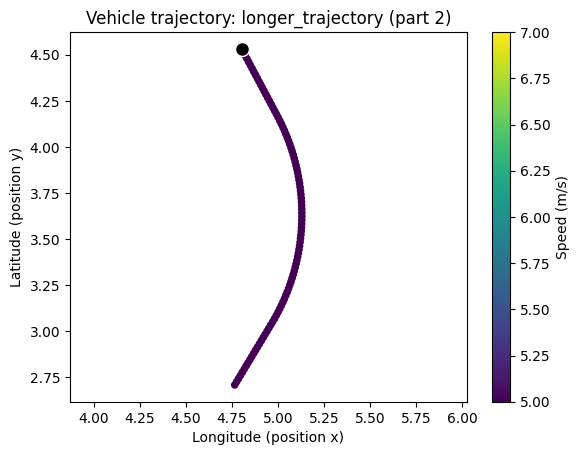

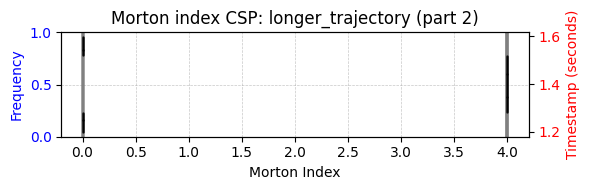

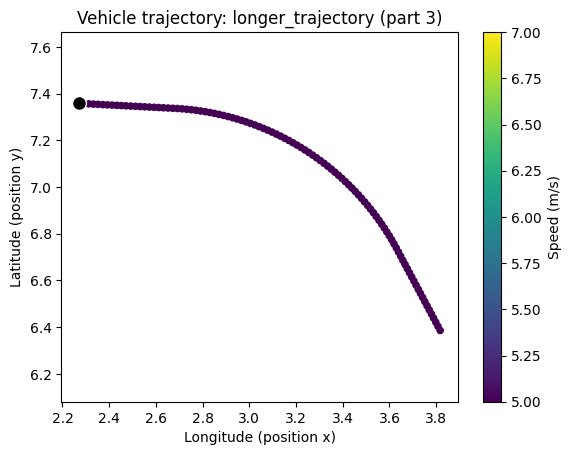

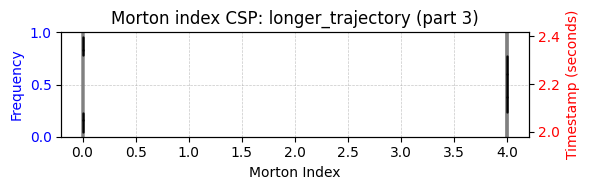

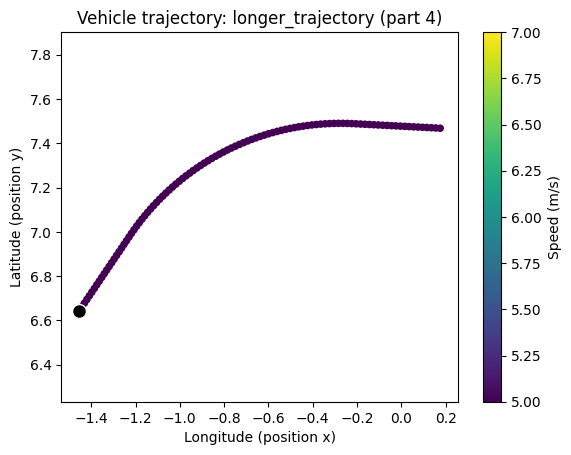

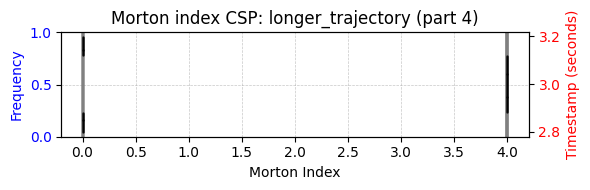

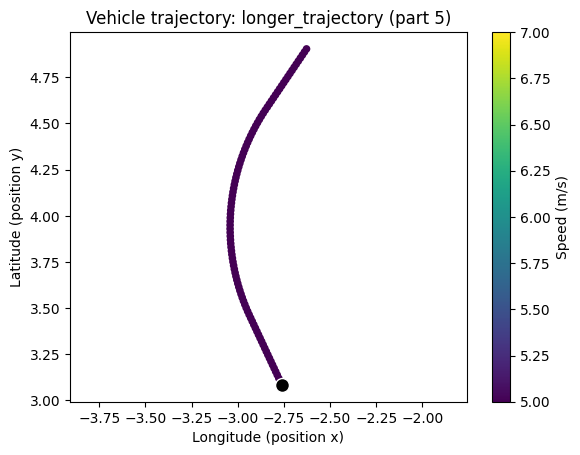

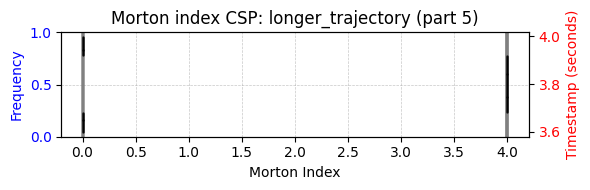

In [24]:
data['Morton_Index'] = [z.interlace(int(x), int(y), bits_per_dim=6) for x, y in zip(data["accel_x"], data["accel_y"])]
data_complete = data

for m in range(num_turns):
    data = data_complete.iloc[2*(m + 1)*length_tramo-length_tramo:2*(m + 1)*length_tramo, :]

    plt.figure()
    plt.scatter(data['x'], data['y'], c=data['speed'], cmap='viridis', s=20, vmin=5, vmax=7)
    plt.colorbar(label="Speed (m/s)")
    plt.scatter(data.iloc[-1]['x'], data.iloc[-1]['y'], s=100, color="black", edgecolors="white")
    plt.xlabel("Longitude (position x)")
    plt.ylabel("Latitude (position y)")
    plt.title(f"Vehicle trajectory: {file_basename} (part {m+1})")
    plt.axis('equal')
    plt.savefig("results/synthetic_trajectories/"+str(m)+".png")
    plt.show()
    plt.close()

    # -------------------------------
    # Build Morton (Z-order) Index (if chosen or if building both)
    # -------------------------------
    
    accel_x = (data["accel_x"] + 10) * 100.0
    accel_y = (data["accel_y"] + 10) * 100.0
    
    fig, ax1 = plt.subplots(figsize=(6,2))
    ax1.eventplot(data['Morton_Index'], orientation='horizontal', colors=["gray"], alpha=0.5, lineoffsets=0.5)
    ax1.set_xlabel("Morton Index")
    ax1.set_ylabel('Frequency', color='b')
    ax1.set_ylim((0, 1))
    ax1.tick_params(axis='y', labelcolor='b')
    ax2 = ax1.twinx()
    ax2.scatter(data['Morton_Index'], data['timestamp']/1000000.0, color='black', s=0.5, alpha=0.8, label="Timestamps")
    ax2.set_ylabel("Timestamp (seconds)", color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    # ax1.set_xlim(0, 20000000) #set once the CSPs are analysed!
    plt.title(f"Morton index CSP: {file_basename} (part {m+1})")
    ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    # plt.savefig("results/synthetic_trajectories/12bits/"+str(m)+".png")
    plt.show()
    plt.close()